# Training and Evaluation Comparison for SmolLM2-135M

This notebook provides a detailed comparison of the training and evaluation processes for the SmolLM2-135M language model. It includes code snippets, performance metrics, and visualizations to help understand the model's capabilities.

In [9]:
import sys
from pathlib import Path
# import importlib
import json
import os

# --------------------------------------------------
# Project root bootstrap
# --------------------------------------------------

PROJECT_ROOT = '..'
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Import the necessary modules to get the logging data
from src.evaluation.log_analysis import parse_trainer_log

In [ ]:
# Define the model paths and evaluation paths # CHANGE APPRIOPRIATELY
base_evaluation_path = Path("../evaluations/eval_exp_-02_SmolLM2-135M_base_final_test")
layer_removed_evaluation_path = Path("../evaluations/eval_exp_-01_SmolLM2-135M_layer_removed_final_test")
original_evaluation_path = Path("../evaluations/eval_exp_010_SmolLM2-135M_base_final_test") # Base model trained for 0 epochs

## Comparison of Generated Samples

Now, we compare generation capability (continuation of given prompts) of the following models:
- Trained base model (SmolLM2-135M with all layers, fine-tuned)
- Trained layer-removed model (SmolLM2-135M with one layer removed, fine-tuned)
- Original pre-trained SmolLM2-135M model (no fine-tuning)

Additionally, we include the original continuations from the dataset for reference.

For the analysis, we use three samples from test set not seen by the model during training or validation.

In [11]:
# Get the generated samples
def read_jsonl(path: Path):
    with open(path, "r") as f:
        return [json.loads(line) for line in f if line.strip()]
base_samples = read_jsonl(base_evaluation_path / "generated_samples.jsonl")
layer_removed_samples = read_jsonl(layer_removed_evaluation_path / "generated_samples.jsonl")
original_samples = read_jsonl(original_evaluation_path / "generated_samples.jsonl")

# Display the first 3 samples from each model for comparison
def print_sample(index: int, n_characters: int = 300):
    print(f"Sample {index}:\n")
    prompt = base_samples[index]['prompt_text']
    print("Prompt: ")
    print(prompt)
    print("-"*50)
    print("True Continuation: ")
    print(base_samples[index]['true_text'].replace(prompt, '')[:n_characters])
    print("-"*50)
    print("Base Model Output:")
    print(base_samples[index]['generated_text'].replace(prompt, '')[:n_characters])
    print("-"*50)
    print("Layer Removed Model Output:")
    print(layer_removed_samples[index]['generated_text'].replace(prompt, '')[:n_characters])
    print("-"*50)
    print("Original Model Output:")
    print(original_samples[index]['generated_text'].replace(prompt, '')[:n_characters])
    print("="*50)

for i in range(3):
    print_sample(i)

Sample 0:

Prompt: 
Björn Lellmann, Head of Customer Racing at BMW M Motorsport:
“At the very top of my success list this week is
--------------------------------------------------
True Continuation: 
 not a race result –
  as impressive as they were. I am absolutely thrilled that starting
  from the 2026 season, we will have our own cup class for the BMW M2
  Racing in the NLS. This is exactly the kind of application we
  developed our new entry-level model for. It definitely belongs on the
  No
--------------------------------------------------
Base Model Output:
 the BMW M Hybrid EV3. I’m very happy with the performance and the performance of the BMW M Hybrid EV3. I’m very happy with the BMW M Hybrid EV3. I’m very happy with the BMW M Hybrid EV3. I’m very happy with the BMW M Hybrid EV3. I’m very happy with the BMW M Hybrid EV3. I’m very happy with the BMW 
--------------------------------------------------
Layer Removed Model Output:
 the BMW M Hybrid. I’m very happy with the BMW M

### Discussion of generated samples

From inspection of the generated samples, we observe that the trained base and trained layer-removed models do not produce perfect outputs. Both models stuck into repeating a certain sentence over and over again. Also, there is not much difference between the base and layer-removed models in terms of output quality.

At the same time, the trained models (base and layer-removed) produce outputs that are significantly better than the original pre-trained SmolLM2-135M model, which either stucks into repeatinng a similar two word phrase (Sample 0 or 2 - '*-litre'/'*-inch-wide') or generates completely irrelevant text (Sample 1 - text about flowers and blue sky). 

The fine-tuning process has clearly improved the model's ability to generate contextually relevant text, even if it is not perfect. For improving the output quality further, one needs more data and possibly longer training times. Furthermore, the original model is quite small (135M parameters), which limits its capacity to learn complex patterns in the data. Ideally, one would use a larger model e.g. 1.1B parameters or more.

## Comparison of Evaluation Metrics

In [20]:
# Load the evaluation metrics
def load_metrics(path: Path):
    with open(path / "metrics.json", "r") as f:
        return json.load(f)

base_metrics = load_metrics(base_evaluation_path)
layer_removed_metrics = load_metrics(layer_removed_evaluation_path)
original_metrics = load_metrics(original_evaluation_path)

# Print comparison of key metrics
metrics_to_compare = ["perplexity", "eval_loss", "eval_runtime"]

print("Comparison of Evaluation Metrics:\n")
for metric in metrics_to_compare:
    base_value = base_metrics.get(metric, "N/A")
    layer_removed_value = layer_removed_metrics.get(metric, "N/A")
    original_value = original_metrics.get(metric, "N/A")
    print(f"{metric}:")
    print(f"  Base Model: {base_value}")
    print(f"  Layer Removed Model: {layer_removed_value}")
    print(f"  Original Model: {original_value}")
    print("-"*30)

Comparison of Evaluation Metrics:

perplexity:
  Base Model: 14.932479252954469
  Layer Removed Model: 15.684745978366902
  Original Model: 30.674074120644324
------------------------------
eval_loss:
  Base Model: 2.703538656234741
  Layer Removed Model: 2.7526886463165283
  Original Model: 3.423417806625366
------------------------------
eval_runtime:
  Base Model: 23.8161
  Layer Removed Model: 23.0969
  Original Model: 20.2221
------------------------------


### Discussion of evaluation metrics

From the evaluation metrics, we can see that both the trained base and layer-removed models outperform the original pre-trained SmolLM2-135M model on the loss and the perplexity (exp(loss)) metrics. This indicates that the fine-tuning process has improved the model's ability to predict the next token in the sequence. Both trained models have similar performance, with the base model having a slightly lower loss and perplexity than the layer-removed model. This suggests that while removing a layer negatively impacts the model's performance.

## Training Logs Analysis

Now, we analyse and compare the training logs of the base and layer-removed models to see how their training dynamics differed,
specifically, whether removing a layer had any noticeable impact on training speed.

In [14]:
# Define the log paths for both models
base_log_path = Path("../experiments/exp_-02_SmolLM2-135M_base/logs/trainer.log")
layer_removed_log_path = Path("../experiments/exp_-01_SmolLM2-135M_layer_removed/logs/trainer.log")

# Parse the training logs
base_log_data = parse_trainer_log(base_log_path)
layer_removed_log_data = parse_trainer_log(layer_removed_log_path)

print(base_log_data['train'])

[{'step': 1, 'loss': 3.178, 'grad_norm': 3.239957094192505, 'learning_rate': 0.0, 'epoch': 0.004550625711035267}, {'step': 2, 'loss': 3.1651, 'grad_norm': 3.076622486114502, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.009101251422070534}, {'step': 3, 'loss': 3.4272, 'grad_norm': 3.2593159675598145, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.013651877133105802}, {'step': 4, 'loss': 3.3633, 'grad_norm': 3.3022451400756836, 'learning_rate': 1.2e-05, 'epoch': 0.01820250284414107}, {'step': 5, 'loss': 3.5011, 'grad_norm': 3.5106568336486816, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.022753128555176336}, {'step': 6, 'loss': 3.2608, 'grad_norm': 3.3430888652801514, 'learning_rate': 2e-05, 'epoch': 0.027303754266211604}, {'step': 7, 'loss': 3.0736, 'grad_norm': 3.247588872909546, 'learning_rate': 1.9954022988505748e-05, 'epoch': 0.03185437997724687}, {'step': 8, 'loss': 3.1528, 'grad_norm': 3.3207318782806396, 'learning_rate': 1.9908045977011498e-05, 'epoch': 0.0364050

In [15]:
# Print the per step training time for both models
print("Training Time per Step Comparison:\n")
print(f"Base Model - Average Time per Step: {base_log_data['summary'][0]['train_steps_per_second']:.4f} steps/sec")
print(f"Layer Removed Model - Average Time per Step: {layer_removed_log_data['summary'][0]['train_steps_per_second']:.4f} steps/sec")
# Print total flos for both models
print(f"Base Model - Total FLOs: {base_log_data['summary'][0]['total_flos']:.2e}")
print(f"Layer Removed Model - Total FLOs: {layer_removed_log_data['summary'][0]['total_flos']:.2e}")
# Print train runtime for both models
print(f"Base Model - Train Runtime: {base_log_data['summary'][0]['train_runtime']:.2f} seconds")
print(f"Layer Removed Model - Train Runtime: {layer_removed_log_data['summary'][0]['train_runtime']:.2f} seconds")

Training Time per Step Comparison:

Base Model - Average Time per Step: 1.3660 steps/sec
Layer Removed Model - Average Time per Step: 1.4130 steps/sec
Base Model - Total FLOs: 2.87e+14
Layer Removed Model - Total FLOs: 2.77e+14
Base Model - Train Runtime: 322.05 seconds
Layer Removed Model - Train Runtime: 311.35 seconds


### Training Time Comparison

From the training logs, we observe that optimisation of the base model was operation at 1.366 steps/sec, while the layer-removed model trained at 1.413 steps/sec. This indicates that removing a layer did indeed speed up the training process, as expected, since there are fewer parameters to update during each training step.
In total, the training of the base model took 3% more time than the layer-removed model.

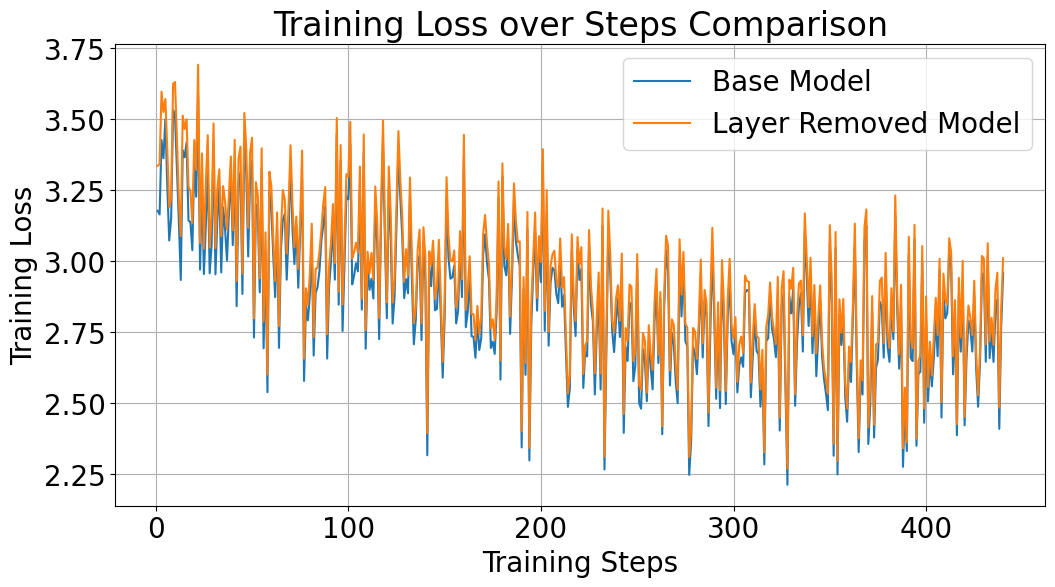

In [ ]:
# Plotting training loss over steps for both models
import matplotlib.pyplot as plt

base_log_data_losses = [entry['loss'] for entry in base_log_data['train']]
layer_removed_log_data_losses = [entry['loss'] for entry in layer_removed_log_data['train']]
steps = list(range(1, len(base_log_data_losses) + 1))

plt.rcParams['font.size'] = 20
plt.figure(figsize=(12, 6))
plt.plot(steps, base_log_data_losses, label='Base Model')
plt.plot(steps, layer_removed_log_data_losses, label='Layer Removed Model')
plt.xlabel('Training Steps')
plt.ylabel('Training Loss')
plt.title('Training Loss over Steps Comparison')
plt.legend()
plt.grid()
plt.tight_layout()
# Save the plot
os.makedirs("images", exist_ok=True)
plt.savefig("images/SmolLM2-135M_training_loss_comparison.png")
plt.show()

### Training Loss Comparison Plot

The training loss curves for both the base and layer-removed models are plotted above. The loss for the base model is decaying slightly faster than for the layer-removed model, indicating better learning capacity. This aligns with the evaluation metrics, where the base model achieved a slightly lower loss and perplexity compared to the layer-removed model.

At the same time, we note that the training loss curves overlap significantly in relation to the noise of the loss curves, execmplifying that both models learned using the same training parameters and on the same sequential data distribution.